In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import copy
from networks import DQN

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
print("Torch Version: ", torch.__version__)

Device:  cuda
Torch Version:  1.0.1.post2


In [14]:
def increase_capacity_keep_lr(network, capacity, optimizer, device):
    # Store old ids
    old_ids = [id(p) for p in network.parameters()]
    old_param_sizes = [p.size() for p in network.parameters()]

    network.increase_capacity(capacity)

    # Store new ids
    new_ids = [id(p) for p in network.parameters()]
    new_param_sizes = [p.size() for p in network.parameters()]

    # Store old state 
    opt_state_dict = optimizer.state_dict()
    for old_id, new_id, new_param_size, old_param_size in zip(old_ids, new_ids, new_param_sizes, old_param_sizes):
        # Store step, and exp_avgs
        step = opt_state_dict['state'][old_id]['step']
        old_exp_avg = opt_state_dict['state'][old_id]['exp_avg']
        old_exp_avg_sq = opt_state_dict['state'][old_id]['exp_avg_sq']
        old_max_exp_avg_sq = opt_state_dict['state'][old_id]['max_exp_avg_sq']

        exp_avg = torch.zeros(new_param_size)
        exp_avg_sq = torch.zeros(new_param_size)
        max_exp_avg_sq =  torch.zeros(new_param_size)
        # Extend exp_avgs to new shape depending on wether param is bias or weight
        if exp_avg.dim()>1:
            # Weights
            exp_avg[0:old_param_size[0],0:old_param_size[1]] = old_exp_avg
            exp_avg_sq[0:old_param_size[0],0:old_param_size[1]] = old_exp_avg_sq
            max_exp_avg_sq[0:old_param_size[0],0:old_param_size[1]] = old_max_exp_avg_sq
        else:
            # Biases/last layer
            exp_avg[0:old_param_size[0]] = old_exp_avg
            exp_avg_sq[0:old_param_size[0]] = old_exp_avg_sq
            max_exp_avg_sq[0:old_param_size[0]] = old_max_exp_avg_sq
        
        # Delete old id from state_dict and update new params and new id
        del opt_state_dict['state'][old_id]
        opt_state_dict['state'][new_id] = {
            'step': step,
            'exp_avg': exp_avg,
            'exp_avg_sq': exp_avg_sq.to(device),
            'max_exp_avg_sq' : max_exp_avg_sq.to(device)
        }
        opt_state_dict['param_groups'][0]['params'].remove(old_id)
        opt_state_dict['param_groups'][0]['params'].append(new_id)

    network.to(device)
    optimizer = optim.Adam(network.parameters(), amsgrad=True)
    optimizer.load_state_dict(opt_state_dict)
    
    return network, optimizer

In [15]:
def generate_zero():
    return random.uniform(0, 49) / 100

def generate_one():
    return random.uniform(50, 100) / 100

def generate_both(num_data_points, p):
    Xs, Ys = [], []
    for _ in range(num_data_points):
        if random.random() < p:
            Xs.append([generate_zero(), generate_zero(), 0]); Ys.append([0])
            # or(1, 0) -> 1
            Xs.append([generate_one(), generate_zero(), 0]); Ys.append([1])
            # or(0, 1) -> 1
            Xs.append([generate_zero(), generate_one(), 0]); Ys.append([1])
            # or(1, 1) -> 1
            Xs.append([generate_one(), generate_one(), 0]); Ys.append([1])
        else:
            # xor(0, 0) -> 0
            Xs.append([generate_zero(), generate_zero(), 1]); Ys.append([0])
            # xor(1, 0) -> 1
            Xs.append([generate_one(), generate_zero(), 1]); Ys.append([1])
            # xor(0, 1) -> 1
            Xs.append([generate_zero(), generate_one(), 1]); Ys.append([1])
            # xor(1, 1) -> 0
            Xs.append([generate_one(), generate_one(), 1]); Ys.append([0])
    return Xs, Ys

def generate_or_XY(num_data_points):
    Xs, Ys = [], []
    for _ in range(num_data_points):
        # or(0, 0) -> 0 
        Xs.append([generate_zero(), generate_zero(), 0]); Ys.append([0])
        # or(1, 0) -> 1
        Xs.append([generate_one(), generate_zero(), 0]); Ys.append([1])
        # or(0, 1) -> 1
        Xs.append([generate_zero(), generate_one(), 0]); Ys.append([1])
        # or(1, 1) -> 1
        Xs.append([generate_one(), generate_one(), 0]); Ys.append([1])
    return Xs, Ys

def generate_xor_XY(num_data_points):
    Xs, Ys = [], []
    for _ in range(num_data_points):
        # xor(0, 0) -> 0 
        Xs.append([generate_zero(), generate_zero(), 1]); Ys.append([0])
        # xor(1, 0) -> 1
        Xs.append([generate_one(), generate_zero(), 1]); Ys.append([1])
        # xor(0, 1) -> 1
        Xs.append([generate_zero(), generate_one(), 1]); Ys.append([1])
        # xor(1, 1) -> 0
        Xs.append([generate_one(), generate_one(), 1]); Ys.append([0])
    return Xs, Ys

In [20]:
def xor_experiments(initial_capacity, train_or, capacity):
    lowest_loss = 0
    lowest_settings = []
    
    pre_pre_loss_or = []
    pre_pre_loss_xor = []
    
    pre_loss_or = []
    pre_loss_xor = []
    
    losses_or = []
    losses_xor = []
    for seed in range(100):
        # Set seeds
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Initialisation network
        network = DQN(3, initial_capacity.copy(), 1, F.relu)
        optimizer = optim.Adam(network.parameters(), amsgrad=True)
        criterion = nn.MSELoss()
        
        prediction = network(torch.tensor([[0,0,0],[0,1,0],[1,0,0],[1,1,0]], dtype=torch.float))
        Ys = torch.tensor([[0],[1],[1],[1]], dtype=torch.float)
        OR_loss = 1.0/(1.0+criterion(prediction, Ys))
            
        prediction = network(torch.tensor([[0,0,1],[0,1,1],[1,0,1],[1,1,1]], dtype=torch.float))
        Ys = torch.tensor([[0],[1],[1],[0]], dtype=torch.float)
        XOR_loss = 1.0/(1.0+criterion(prediction, Ys))
            
        pre_pre_loss_or.append(OR_loss.item())
        pre_pre_loss_xor.append(XOR_loss.item())
        
        if train_or:
            for i in range(37*1000):
                optimizer.zero_grad()

                Xs, Ys = generate_both(25,0.1)
                    
                Xs = torch.tensor(Xs)
                Ys = torch.tensor(Ys, dtype=torch.float)

                prediction = network(Xs)
                loss = criterion(prediction, Ys)

                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    # Evaluation
                    prediction = network(torch.tensor([[0,0,0],[0,1,0],[1,0,0],[1,1,0]], dtype=torch.float))
                    Ys = torch.tensor([[0],[1],[1],[1]], dtype=torch.float)
                    loss = 1.0/(1.0+criterion(prediction, Ys))

                if loss>0.95:
                    break
                    
        prediction = network(torch.tensor([[0,0,0],[0,1,0],[1,0,0],[1,1,0]], dtype=torch.float))
        Ys = torch.tensor([[0],[1],[1],[1]], dtype=torch.float)
        OR_loss = 1.0/(1.0+criterion(prediction, Ys))
            
        prediction = network(torch.tensor([[0,0,1],[0,1,1],[1,0,1],[1,1,1]], dtype=torch.float))
        Ys = torch.tensor([[0],[1],[1],[0]], dtype=torch.float)
        XOR_loss = 1.0/(1.0+criterion(prediction, Ys))
            
        pre_loss_or.append(OR_loss.item())
        pre_loss_xor.append(XOR_loss.item())
        
        if capacity is not None:
            network, optimizer = increase_capacity_keep_lr(network, capacity, optimizer, 'cpu')
        
        iters = 41*1000
        if not train_or:
            iters * 2
            
        for i in range(iters):
            optimizer.zero_grad()
            
            # Uniform syllabus 20% of the time
            Xs, Ys = generate_both(25,0.9)
                
            Xs = torch.tensor(Xs)
            Ys = torch.tensor(Ys, dtype=torch.float)

            prediction = network(Xs)
            loss = criterion(prediction, Ys)

            loss.backward()
            optimizer.step()
        
        average_loss = 0
        
        with torch.no_grad():
            # Test or
            prediction = network(torch.tensor([[0,0,0],[0,1,0],[1,0,0],[1,1,0]], dtype=torch.float))
            Ys = torch.tensor([[0],[1],[1],[1]], dtype=torch.float)
            loss = 1.0/(1.0+criterion(prediction, Ys))
        
        average_loss += loss.item()
        losses_or.append(loss.item())

        with torch.no_grad():
            # Test xor
            prediction = network(torch.tensor([[0,0,1],[0,1,1],[1,0,1],[1,1,1]], dtype=torch.float))
            Ys = torch.tensor([[0],[1],[1],[0]], dtype=torch.float)
            loss = 1.0/(1.0+criterion(prediction, Ys))
        
        average_loss += loss.item()
        average_loss /= 2
        losses_xor.append(loss.item())
        
        if average_loss > lowest_loss:
            lowest_loss = copy.copy(average_loss)
            lowest_settings = [average_loss, losses_or[-1], losses_xor[-1], seed, initial_capacity, train_or, capacity]
        
        if loss>0.95:
            break
        
    # Print statistics
    print(initial_capacity, train_or, capacity)
    
    print('Average loss or before xor training: ', np.average(pre_pre_loss_or))
    print('Average loss xor before xor training: ', np.average(pre_pre_loss_xor))
    
    print('Average loss or before xor training: ', np.average(pre_loss_or))
    print('Average loss xor before xor training: ', np.average(pre_loss_xor))
    print('Average loss or: ', np.average(losses_or))
    print('Average loss xor: ', np.average(losses_xor))
    print('Average loss: ', (np.average(losses_or) +  np.average(losses_xor))/2)
    print(lowest_settings)


xor_experiments([2],False, None)
xor_experiments([2], True, None)
xor_experiments([1], True, [1])

xor_experiments([3],False,None)
xor_experiments([3], True, None)
xor_experiments([2], True, [1])
xor_experiments([1], True, [2])

xor_experiments([4],False,None)
xor_experiments([4], True, None)
xor_experiments([1], True, [3])
xor_experiments([2], True, [2])
xor_experiments([3], True, [1])

[2] False None
Average loss or before xor training:  0.5666652438044548
Average loss xor before xor training:  0.6165286988019943
Average loss or before xor training:  0.5666652438044548
Average loss xor before xor training:  0.6165286988019943
Average loss or:  0.923716379404068
Average loss xor:  0.766582578420639
Average loss:  0.8451494789123535
[0.9461823105812073, 0.9936859011650085, 0.898678719997406, 52, [2], False, None]
644
793
577
6010
11895
[2] True None
Average loss or before xor training:  0.5666652438044548
Average loss xor before xor training:  0.6165286988019943
Average loss or before xor training:  0.8549469441175461
Average loss xor before xor training:  0.8341650491952897
Average loss or:  0.9273117077350617
Average loss xor:  0.7729986488819123
Average loss:  0.850155178308487
[0.9454349875450134, 0.9938973784446716, 0.8969725966453552, 96, [2], True, None]
[1] True [1]
Average loss or before xor training:  0.5736202634871006
Average loss xor before xor training:  

In [32]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=24, metadata=dict(artist='Joe Harrison'), bitrate=1800)

0 0.8552559614181519
1 0.9450685381889343
2 0.8479112982749939
3 0.8452067971229553
4 0.8431272506713867
5 0.8419037461280823
6 0.8403158783912659
7 0.853485643863678
8 0.8190130591392517
9 0.8330321311950684
10 0.8607609868049622
11 0.8887335658073425
12 0.8406065702438354
13 0.8083235621452332
14 0.8525921106338501
15 0.8209795951843262
16 0.8337359428405762
17 0.8464990854263306
18 0.8744804263114929
19 0.8732001781463623
20 0.8718239068984985
21 0.8252975940704346
22 0.8088929057121277
23 0.8660187125205994
24 0.8351905941963196
25 0.8483043313026428
26 0.8612344861030579
27 0.801175594329834
28 0.8433561325073242
29 0.8272910714149475
30 0.825671374797821
31 0.8386083245277405
32 0.8080980181694031
33 0.8065598011016846
34 0.8194347620010376
35 0.8324432373046875
36 0.8019487857818604
37 0.8004421591758728
38 0.7990315556526184
39 0.7830743193626404
40 0.7959089875221252
41 0.8230062127113342
42 0.8216138482093811
43 0.8199988603591919
44 0.8042615652084351
45 0.8311848640441895
4

359 0.25323063135147095
360 0.2610549330711365
361 0.2551250159740448
362 0.2639027237892151
363 0.25560733675956726
364 0.25369173288345337
365 0.25213244557380676
366 0.2588612735271454
367 0.2515970766544342
368 0.26022061705589294
369 0.25410306453704834
370 0.2586001753807068
371 0.2528402805328369
372 0.252511590719223
373 0.260211706161499
374 0.24943773448467255
375 0.25179004669189453
376 0.2567742168903351
377 0.25429844856262207
378 0.26269152760505676
379 0.2514294981956482
380 0.25524723529815674
381 0.2608136534690857
382 0.25660353899002075
383 0.25541526079177856
384 0.2510131299495697
385 0.2528967261314392
386 0.25573399662971497
387 0.2569952607154846
388 0.25276893377304077
389 0.2513931393623352
390 0.25748172402381897
391 0.2587720453739166
392 0.25585606694221497
393 0.25326260924339294
394 0.2524624168872833
395 0.25284233689308167
396 0.24664589762687683
397 0.2600404620170593
398 0.2571449279785156
399 0.25478118658065796
400 0.25792115926742554
401 0.25859108

211 0.15177854895591736
212 0.12468124181032181
213 0.14028051495552063
214 0.14338894188404083
215 0.134041890501976
216 0.12157458066940308
217 0.13371233642101288
218 0.14199139177799225
219 0.12691929936408997
220 0.1627533882856369
221 0.13165035843849182
222 0.1486794799566269
223 0.13653267920017242
224 0.14311279356479645
225 0.16049237549304962
226 0.11671725660562515
227 0.1303177922964096
228 0.13496075570583344
229 0.12444890290498734
230 0.12959066033363342
231 0.15571331977844238
232 0.15834420919418335
233 0.1474006474018097
234 0.1190827265381813
235 0.16836807131767273
236 0.14310632646083832
237 0.14346548914909363
238 0.13373439013957977
239 0.1154412105679512
240 0.14146891236305237
241 0.14503788948059082
242 0.1472846269607544
243 0.12150600552558899
244 0.13131406903266907
245 0.13532134890556335
246 0.1575714647769928
247 0.13636338710784912
248 0.12845712900161743
249 0.1625880002975464
250 0.12528052926063538
251 0.12990307807922363
252 0.14700758457183838
253

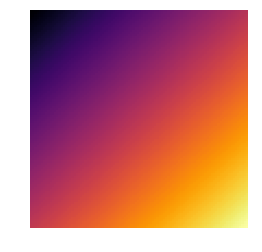

In [34]:
fig = plt.figure()

with writer.saving(fig, 'xor.mp4' ,100):
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    
    x = np.linspace(0, 1.0, 100)
    y = np.linspace(0, 1.0, 100)
    
    network = DQN(3, [6,3], 1, F.leaky_relu)
    optimizer = optim.Adam(network.parameters(), amsgrad=True)
    criterion = nn.MSELoss()
    
    for i in range(500):
        
        optimizer.zero_grad()

        Xs, Ys = generate_both(25,0.1)
                    
        Xs = torch.tensor(Xs)
        Ys = torch.tensor(Ys, dtype=torch.float)

        prediction = network(Xs)
        loss = criterion(prediction, Ys)

        loss.backward()
        optimizer.step()
        
        print(i, loss.item())

        OR_mat = np.zeros((100,100))
        XOR_mat = np.zeros((100,100))

        for idx_y, grid_point_y in enumerate(y):
            for idx_x, grid_point_x in enumerate(x):
                OR_mat[idx_y, idx_x] = network(torch.tensor([grid_point_x, grid_point_y, 0.0])).item()
                XOR_mat[idx_y, idx_x] = network(torch.tensor([grid_point_x, grid_point_y, 1.0])).item()

        plt.axis('off')
        
#         plt.subplot(1, 2, 1)
#         plt.axvline(x=0.5, color='w', linestyle='dashed')
#         plt.axhline(y=0.5, color='w', linestyle='dashed')
#         plt.xticks(np.arange(min(x), max(x)+1, 0.5))
#         plt.yticks(np.arange(min(y), max(y)+1, 0.5))
#         plt.imshow(OR_mat, interpolation='none', cmap='inferno', extent=(0.0, 1.0, 0.0, 1.0))
#         plt.subplot(1, 2, 2)
#         plt.axvline(x=0.5, color='w', linestyle='dashed')
#         plt.axhline(y=0.5, color='w', linestyle='dashed')
#         plt.xticks(np.arange(min(x), max(x)+1, 0.5))
#         plt.yticks(np.arange(min(y), max(y)+1, 0.5))
        plt.imshow(XOR_mat, interpolation='none', cmap='inferno', extent=(0.0, 1.0, 0.0, 1.0))
        
        writer.grab_frame()
    
    for i in range(500):
       
        optimizer.zero_grad()

        Xs, Ys = generate_both(25,0.9)
                    
        Xs = torch.tensor(Xs)
        Ys = torch.tensor(Ys, dtype=torch.float)

        prediction = network(Xs)
        loss = criterion(prediction, Ys)

        loss.backward()
        optimizer.step()
        
        print(i, loss.item())

        OR_mat = np.zeros((100,100))
        XOR_mat = np.zeros((100,100))

        for idx_y, grid_point_y in enumerate(y):
            for idx_x, grid_point_x in enumerate(x):
                OR_mat[idx_y, idx_x] = network(torch.tensor([grid_point_x, grid_point_y, 0.0])).item()
                XOR_mat[idx_y, idx_x] = network(torch.tensor([grid_point_x, grid_point_y, 1.0])).item()

        plt.axis('off')
#         plt.subplot(1, 2, 1)
#         plt.axvline(x=0.5, color='w', linestyle='dashed')
#         plt.axhline(y=0.5, color='w', linestyle='dashed')
#         plt.xticks(np.arange(min(x), max(x)+1, 0.5))
#         plt.yticks(np.arange(min(y), max(y)+1, 0.5))
#         plt.imshow(OR_mat, interpolation='none', cmap='inferno', extent=(0.0, 1.0, 0.0, 1.0))
#         plt.subplot(1, 2, 2)
#         plt.axvline(x=0.5, color='w', linestyle='dashed')
#         plt.axhline(y=0.5, color='w', linestyle='dashed')
#         plt.xticks(np.arange(min(x), max(x)+1, 0.5))
#         plt.yticks(np.arange(min(y), max(y)+1, 0.5))
        plt.imshow(XOR_mat, interpolation='none', cmap='inferno', extent=(0.0, 1.0, 0.0, 1.0))
        
        writer.grab_frame()

In [ ]:
104